#Energy Consumption Time Series Forecasting

In [1]:
# Install dependencies
!pip install kagglehub[pandas-datasets] prophet xgboost --quiet

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Set the correct file path
file_path = "household_power_consumption.csv"  # main dataset file

# Load the dataset
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "imtkaggleteam/household-power-consumption",
    file_path,
)

print("Shape:", df.shape)
print("First 5 rows:")
print(df.head())


/tmp/ipython-input-2506359497.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 9.12M/9.12M [00:00<00:00, 78.1MB/s]

Extracting zip of household_power_consumption.csv...


Shape: (1048575, 9)
First 5 rows:
         Date      Time Global_active_power Global_reactive_power Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.84   
1  16/12/2006  17:25:00                5.36                 0.436  233.63   
2  16/12/2006  17:26:00               5.374                 0.498  233.29   
3  16/12/2006  17:27:00               5.388                 0.502  233.74   
4  16/12/2006  17:28:00               3.666                 0.528  235.68   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0             18.4              0              1            17.0  
1               23              0              1            16.0  
2               23              0              2            17.0  
3               23              0              1            17.0  
4             15.8              0              1            17.0  


In [5]:
# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Convert Global_active_power to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop missing values
df = df.dropna(subset=['Global_active_power'])

# Set datetime as index
df.set_index('Datetime', inplace=True)

print(df.info())
print(df.head())


/tmp/ipython-input-3082422823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
/tmp/ipython-input-3082422823.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044506 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1044506 non-null  object 
 1   Time                   1044506 non-null  object 
 2   Global_active_power    1044506 non-null  float64
 3   Global_reactive_power  1044506 non-null  object 
 4   Voltage                1044506 non-null  object 
 5   Global_intensity       1044506 non-null  object 
 6   Sub_metering_1         1044506 non-null  object 
 7   Sub_metering_2         1044506 non-null  object 
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(2), object(7)
memory usage: 79.7+ MB
None
                           Date      Time  Global_active_power  \
Datetime                                                         
2006-12-16 17:24:00  16/12/2006  17:24:00                4.216   
2006-

In [6]:
# Resample to hourly average
df_hourly = df['Global_active_power'].resample('H').mean()

print(df_hourly.head(10))


Datetime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
2006-12-16 22:00:00    2.200133
2006-12-16 23:00:00    2.061600
2006-12-17 00:00:00    1.882467
2006-12-17 01:00:00    3.349400
2006-12-17 02:00:00    1.587267
Freq: h, Name: Global_active_power, dtype: float64


/tmp/ipython-input-1494064905.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['Global_active_power'].resample('H').mean()


In [9]:
# Train = up to end of 2007
train = df_hourly[:'2007']
# Test = from 2008 onwards
test = df_hourly['2008':]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (9127,)
Test shape: (8350,)


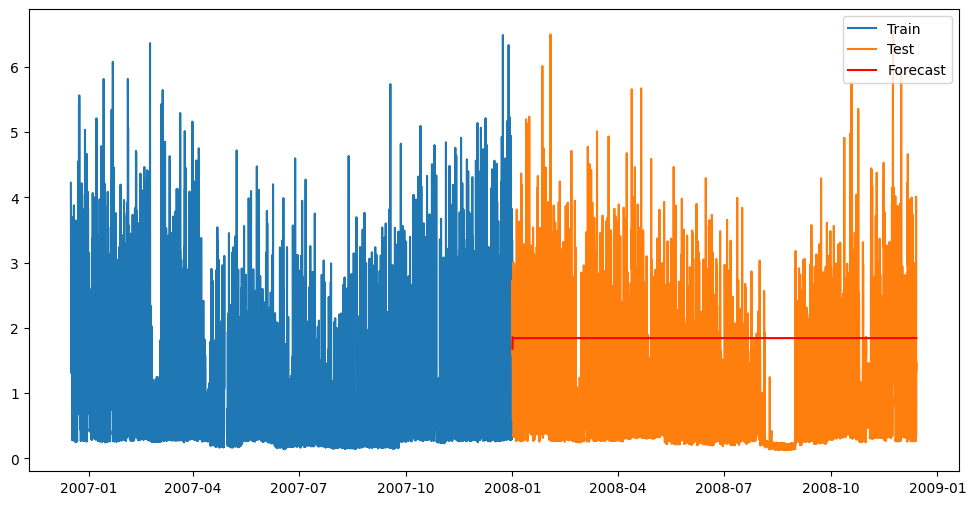

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model on train
model = ARIMA(train, order=(5,1,2), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()


# Forecast same length as test
forecast = model_fit.forecast(steps=len(test))

# Plot train vs test vs forecast
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()


In [14]:
print(model_fit.summary())


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 9127
Model:                  ARIMA(5, 1, 2)   Log Likelihood               -9331.689
Date:                 Thu, 28 Aug 2025   AIC                          18679.377
Time:                         15:26:28   BIC                          18736.324
Sample:                     12-16-2006   HQIC                         18698.742
                          - 12-31-2007                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0288      0.161     -0.179      0.858      -0.344       0.286
ar.L2          0.5282      0.124      4.276      0.000       0.286       0.770
ar.L3         -0.0626      0.017     -3.738 

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print("MSE:", mse, "MAE:", mae)


MSE: 1.4289845343989003 MAE: 1.0565305941809344
